In [1]:
import os
import pandas as pd
import datatable as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Preliminary Exploratory Data Analysis of Trait Values
0. Which trait is more useful for revealing loss of gene function (significantly different from wild type)? Melissa thought of using a wilcoxon test.
1. How does inclusion of the interaction term affect the emmeans?

In [2]:
# 0. Perform Mann-Whitney U tests (Wilcoxon rank-sum tests) for each genotype against WT
from scipy.stats import mannwhitneyu

mwu_res = []
for trait in ['PG', 'DTB', 'LN', 'DTF', 'SN', 'WO', 'FN', 'SPF', 'TSC', 'SH']:
    df = pd.read_csv(f'../data/20240923_melissa_ara_data/corrected_data/fitness_data_for_Kenia_09232024_{trait}_emmeans.tsv', sep='\t')
    
    for set in tsc.Set.unique():
        for genotype in ['MA', 'MB', 'DM']:
            group1 = tsc[(tsc.Set == set) & (tsc.Genotype == 'WT')]['TSC']
            group2 = tsc[(tsc.Set == set) & (tsc.Genotype == genotype)]['TSC']
            stat, p = mannwhitneyu(group1, group2)
            mwu_res.append((trait, set, genotype, stat, p))
            del group1, group2, stat, p
    del df

mwu_res_df = pd.DataFrame(mwu_res, columns=['Trait', 'Set', 'Genotype', 'Statistic', 'p-value'])
mwu_res_df = mwu_res_df.pivot(index='Set', columns=['Trait', 'Genotype'], values='p-value')
mwu_res_df[mwu_res_df < 0.05] = 1
mwu_res_df.fillna(0, inplace=True)

NameError: name 'tsc' is not defined

### Exploratory Data Analysis of Epistasis Calculations
0. Median genotype values (instead of estimated marginal means) to calculate the GI definitions from Mani et al., 2008 PNAS
1. Results from using a linear model
2. Results from using the genotype estimated marginal means to calculate the GI definitions

#### 0. Median genotype values

In [2]:
# Aggregate all individual datasets into one
files = [f'../data/20240923_melissa_ara_data/corrected_data/{f}' for f in\
         os.listdir('../data/20240923_melissa_ara_data/corrected_data')\
         if f.endswith('_medians_epistasis.tsv')]
dataframes = [pd.read_csv(f, index_col=0, header=[0,1], sep='\t') for f in files]
med_res = pd.concat(dataframes, axis=1, ignore_index=False)
med_res

DTF                                                               \
         W_DM      W_MA      W_MB W_WT   epi_min epi_product  epi_additive   
Set                                                                          
1    1.032258  1.032258  1.016129  1.0  0.016129   -0.016649 -1.612903e-02   
2    1.187500  1.125000  1.093750  1.0  0.093750   -0.042969 -3.125000e-02   
3    1.000000  1.032258  1.000000  1.0  0.000000   -0.032258 -3.225806e-02   
5    1.034483  1.034483  1.000000  1.0  0.034483    0.000000  2.220446e-16   
7    1.000000  1.000000  0.964286  1.0  0.035714    0.035714  3.571429e-02   
..        ...       ...       ...  ...       ...         ...           ...   
812  0.965517  0.965517  0.965517  1.0  0.000000    0.033294  3.448276e-02   
813  0.967742  0.967742  0.967742  1.0  0.000000    0.031217  3.225806e-02   
815  1.068966  1.051724  1.034483  1.0  0.034483   -0.019025 -1.724138e-02   
823  1.034483  1.000000  1.000000  1.0  0.034483    0.034483  3.448276e-02   
798       NaN       NaN       NaN  NaN       NaN         NaN           NaN   

                                       ...       SPF                 \
    epi_log2_mani  epi_mean   epi_max  ...      W_MB W_WT   epi_min   
Set                                    ...                            
1       -0.016484  0.008065  0.000000  ...  0.741722  1.0 -0.035320   
2       -0.038764  0.078125  0.062500  ...  0.844660  1.0  0.101942   
3       -0.032258 -0.016129 -0.032258  ...  0.972973  1.0 -0.153153   
5        0.000000  0.017241  0.000000  ...  0.991247  1.0 -0.008542   
7        0.035714  0.017857  0.000000  ...  0.984047  1.0  0.030227   
..            ...       ...       ...  ...       ...  ...       ...   
812      0.033639  0.000000  0.000000  ...  0.884722  1.0 -0.034028   
813      0.031521  0.000000  0.000000  ...  0.889655  1.0  0.300000   
815     -0.018441  0.025862  0.017241  ...  1.168966  1.0  0.072414   
823      0.034483  0.034483  0.034483  ...  0.917291  1.0  0.061000   
798           NaN       NaN       NaN  ...  0.815789  1.0 -0.184211   

                                                                \
    epi_product epi_additive epi_log2_mani  epi_mean   epi_max   
Set                                                              
1     -0.017309    -0.011038     -0.015830 -0.152318 -0.269316   
2      0.011735    -0.004854      0.006896 -0.029126 -0.160194   
3     -0.179450    -0.180180     -0.179674 -0.180180 -0.207207   
5     -0.002858    -0.002808     -0.002843 -0.010052 -0.011561   
7      0.004820     0.004408      0.004693  0.009341 -0.011545   
..          ...          ...           ...       ...       ...   
812   -0.085312    -0.091995     -0.087261 -0.120650 -0.207272   
813    0.062247     0.032759      0.052281  0.111207 -0.077586   
815   -0.145256    -0.113793     -0.132972  0.063793  0.055172   
823    0.005459     0.000451      0.003954 -0.010629 -0.082258   
798   -0.370268    -0.412281     -0.383260 -0.390351 -0.596491   

                                           
    epi_log2_additive epi_log2_difference  
Set                                        
1            1.172916            0.310817  
2            1.043769            0.556655  
3            0.820874            0.741817  
5            1.003685            0.978317  
7            1.000699            0.954297  
..                ...                 ...  
812          0.946104            0.592697  
813          1.016646            0.679282  
815          0.769791            1.220256  
823          1.018028            0.768931  
798          0.628917            0.041455  

[139 rows x 120 columns]

MemoryError for ('PG', 'epi_log2_mani')


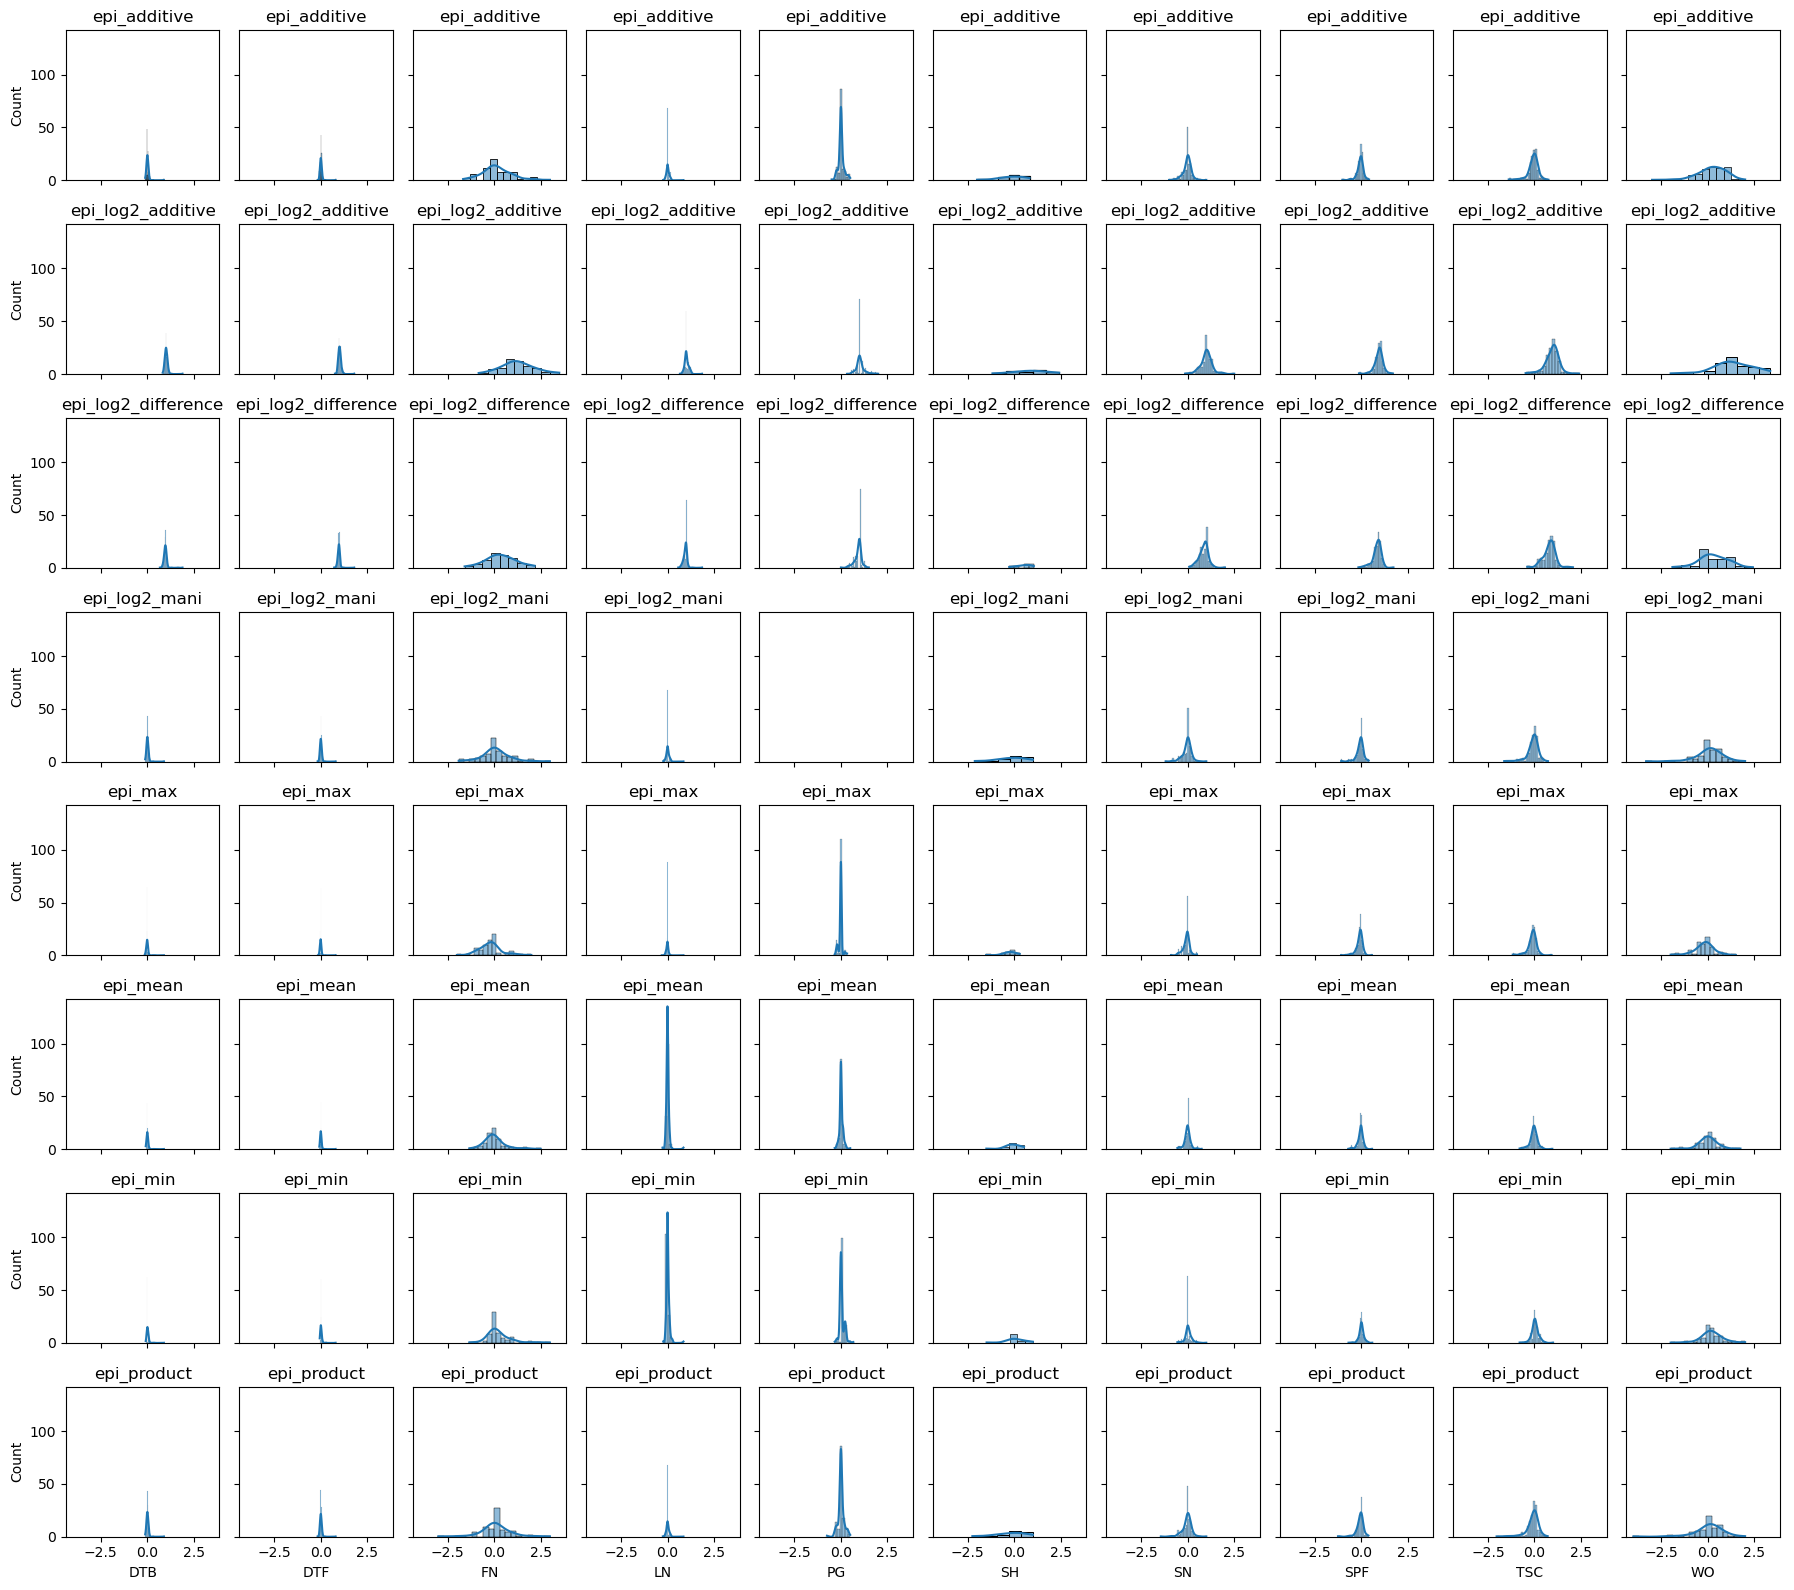

In [3]:
# What is the distribution of epistasis values for each GI definition and trait?
med_res_epi = med_res.loc[:, pd.IndexSlice[:, [c for c in med_res.columns.levels[1] if c.startswith('epi')]]]
med_res_epi = med_res_epi.sort_index(axis=1, level=0)
med_res_epi = med_res_epi.sort_index(axis=1, level=1)

fig, ax = plt.subplots(nrows=8, ncols=10, figsize=(18, 16), sharex=True, sharey=True)
for i, column in enumerate(med_res_epi.columns):
    try:
        sns.histplot(med_res_epi[column].dropna(), ax=ax[i // 10, i % 10], kde=True)
        ax[i // 10, i % 10].set_title(f'{column[1]}')
        ax[i // 10, i % 10].set_xlabel(f'{column[0]}')
        ax[i // 10, i % 10].set_ylabel('Count')
    except MemoryError:
        print(f'MemoryError for {column}')
        continue

plt.tight_layout()

In [4]:
# What is the correlation of epistasis values between traits and GI definitions?
# Note: I couldn't calculate distance to cluster the correlation values because of the error:
# ValueError: The condensed distance matrix must contain only finite values.

med_res_epi_corr = med_res_epi.corr(method='pearson')
med_res_epi_corr

,,DTB,DTF,FN,LN,PG,SH,SN,SPF,TSC,WO,...,DTB,DTF,FN,LN,PG,SH,SN,SPF,TSC,WO
,,epi_additive,epi_additive,epi_additive,epi_additive,epi_additive,epi_additive,epi_additive,epi_additive,epi_additive,epi_additive,...,epi_product,epi_product,epi_product,epi_product,epi_product,epi_product,epi_product,epi_product,epi_product,epi_product
DTB,epi_additive,1.000000,0.924289,-0.108022,0.656818,-0.078274,-0.572466,-0.291397,-0.314912,-0.341303,0.233817,...,0.998614,0.922719,-0.080977,0.646059,-0.080005,-0.522777,-0.278771,-0.291070,-0.297454,0.264795
DTF,epi_additive,0.924289,1.000000,-0.136494,0.710385,-0.036469,-0.367045,-0.253193,-0.327567,-0.325179,0.194808,...,0.932027,0.999820,-0.102523,0.707490,-0.027860,-0.307608,-0.249617,-0.309984,-0.296167,0.223623
FN,epi_additive,-0.108022,-0.136494,1.000000,0.082216,0.129369,NaN,-0.145320,-0.145475,-0.170767,0.357597,...,-0.107823,-0.136229,0.928214,0.083448,0.130284,NaN,-0.132856,-0.120665,-0.125742,0.376815
LN,epi_additive,0.656818,0.710385,0.082216,1.000000,0.067823,0.717103,-0.034011,-0.321702,-0.180193,0.211692,...,0.669614,0.712153,0.106241,0.998222,0.074358,0.739283,-0.053395,-0.298052,-0.153510,0.264041
PG,epi_additive,-0.078274,-0.036469,0.129369,0.067823,1.000000,-0.385335,0.047963,-0.185362,-0.114219,-0.079240,...,-0.078383,-0.037078,0.134603,0.062330,0.986082,-0.365222,0.020591,-0.178689,-0.105970,-0.064749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SH,epi_product,-0.522777,-0.307608,NaN,0.739283,-0.365222,0.995036,0.079195,0.018448,0.209884,NaN,...,-0.526631,-0.314254,NaN,0.771931,-0.388542,1.000000,0.037949,0.017408,0.166017,NaN
SN,epi_product,-0.278771,-0.249617,-0.132856,-0.053395,0.020591,0.077441,0.981444,0.145146,0.553493,-0.299838,...,-0.274201,-0.247724,-0.070884,-0.043865,0.030141,0.037949,1.000000,0.143831,0.530907,-0.247180
SPF,epi_product,-0.291070,-0.309984,-0.120665,-0.298052,-0.178689,0.025038,0.127023,0.990469,0.726310,-0.227216,...,-0.294340,-0.310047,-0.114435,-0.298657,-0.157450,0.017408,0.143831,1.000000,0.730351,-0.249578


In [6]:
med_res_epi_corr = med_res_epi_corr.melt(ignore_index=False).sort_values(by='value', ascending=False)
med_res_epi_corr.loc[med_res_epi_corr['value'] != 1.0].head(20)

variable_0     variable_1     value
DTF epi_product          DTF  epi_log2_mani  0.999981
    epi_log2_mani        DTF    epi_product  0.999981
    epi_additive         DTF  epi_log2_mani  0.999916
    epi_log2_mani        DTF   epi_additive  0.999916
    epi_product          DTF   epi_additive  0.999820
    epi_additive         DTF    epi_product  0.999820
DTB epi_log2_mani        DTB    epi_product  0.999767
    epi_product          DTB  epi_log2_mani  0.999767
LN  epi_log2_mani         LN    epi_product  0.999733
    epi_product           LN  epi_log2_mani  0.999733
DTB epi_log2_mani        DTB   epi_additive  0.999513
    epi_additive         DTB  epi_log2_mani  0.999513
SH  epi_product           SH  epi_log2_mani  0.999446
    epi_log2_mani         SH    epi_product  0.999446
LN  epi_log2_mani         LN   epi_additive  0.999313
    epi_additive          LN  epi_log2_mani  0.999313
DTB epi_additive         DTB    epi_product  0.998614
    epi_product          DTB   epi_additive  0.998614
LN  epi_additive          LN    epi_product  0.998222
    epi_product           LN   epi_additive  0.998222

#### 1. Epistasis as the interaction term coefficient from the linear model

In [2]:
lin_res = pd.read_csv('../data/20240923_melissa_ara_data/corrected_data/fitness_data_for_Kenia_09232024_epistasis_linear.csv')
lin_res

,Set,e_est,lowerCI,upperCI,rsquared,pval_e,Label,Term,sw_test_stat,sw_test_pval,bp_test_stat,bp_test_pval,dw_test_stat,dw_test_pval,Epistasis_Direction
0,1,-3.420484,-13.060786,6.328656,0.020577,0.490694,PG,MA:MB,0.899520,6.759561e-12,NaN,0.192518,NaN,2.180000e-02,Not Detected
1,2,1.468086,-7.384080,10.363765,0.007616,0.746535,PG,MA:MB,0.921270,1.923475e-10,NaN,0.526144,NaN,3.822000e-01,Not Detected
2,3,0.733376,-10.331702,11.716566,0.018024,0.896592,PG,MA:MB,0.959331,1.667148e-06,NaN,0.100694,NaN,3.200000e-03,Not Detected
3,5,0.795857,-9.927141,11.744873,0.008208,0.885741,PG,MA:MB,0.988594,3.661914e-02,NaN,0.009404,NaN,3.576000e-01,Not Detected
4,7,-4.948922,-15.406394,5.637474,0.011038,0.358783,PG,MA:MB,0.894226,1.520047e-12,NaN,0.828178,NaN,9.594000e-01,Not Detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,43,-0.368307,-1.088685,0.352071,0.030060,0.314287,SH_plog10,MA:MB,0.905436,3.949075e-09,8.057602,0.044836,1.663050,1.294761e-02,Not Detected
4644,794,0.180238,-0.688739,1.049215,0.000190,0.682849,SH_plog10,MA:MB,0.773384,1.018529e-15,3.367551,0.338351,1.472085,1.372717e-04,Not Detected
4645,807,0.725111,0.112011,1.338211,0.015436,0.020695,SH_plog10,MA:MB,0.598183,2.902488e-21,5.364732,0.146957,1.671091,1.055808e-02,Positive
4646,795,0.059341,-0.467759,0.586441,0.000183,0.824513,SH_plog10,MA:MB,0.430945,1.205561e-24,2.275597,0.517212,1.269928,1.385478e-07,Not Detected


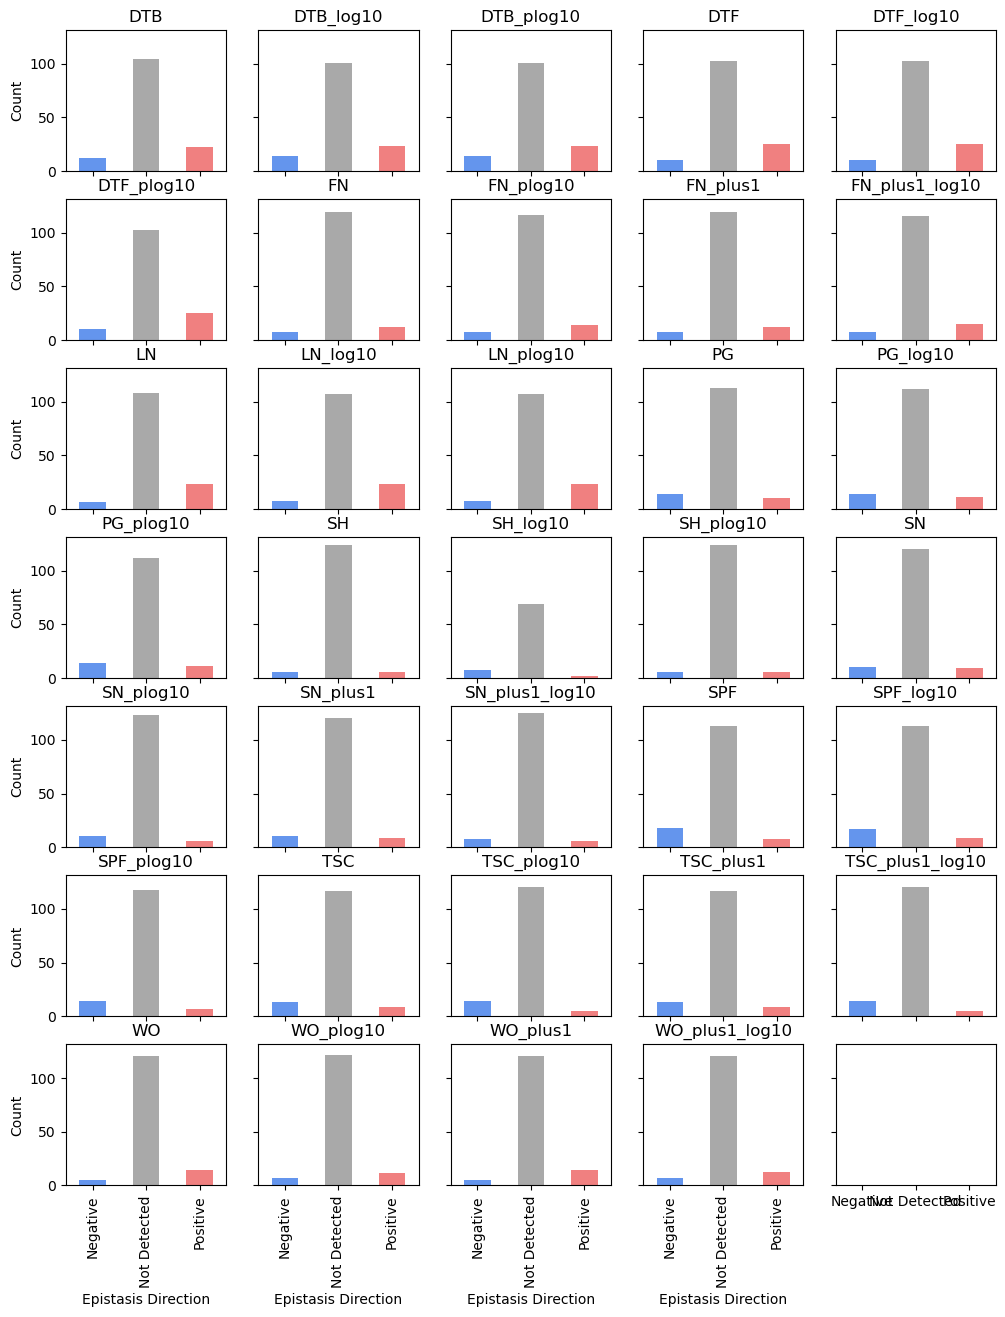

In [3]:
# How many sets per fitness label were found to exhibit epistasis?
lin_res_counts = lin_res.groupby(['Label', 'Epistasis_Direction'])['Set'].count().unstack()

fig, ax = plt.subplots(7, 5, figsize=(12, 15), sharex=True, sharey=True)
for i, (label, counts) in enumerate(lin_res_counts.iterrows()):
    counts.plot(kind='bar', ax=ax[i // 5, i % 5], title=label,
                color=['cornflowerblue', 'darkgray', 'lightcoral'])
    ax[i // 5, i % 5].set_ylabel('Count')
    ax[i // 5, i % 5].set_xlabel('Epistasis Direction')

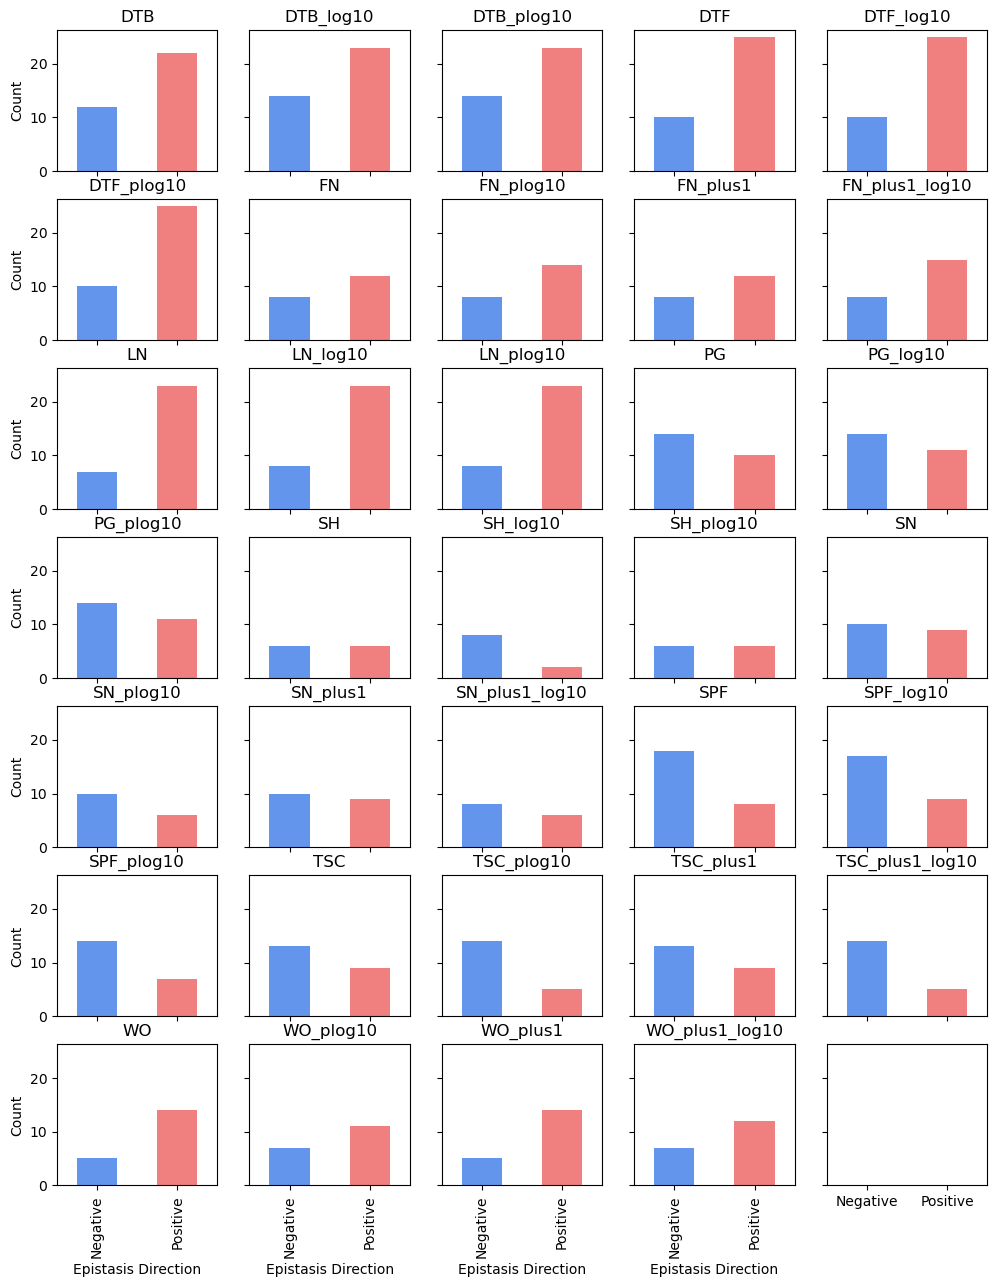

In [4]:
# Look only at the epistatic sets
fig, ax = plt.subplots(7, 5, figsize=(12, 15), sharex=True, sharey=True)
for i, (label, counts) in enumerate(lin_res_counts.drop(columns=['Not Detected']).iterrows()):
    counts.plot(kind='bar', ax=ax[i // 5, i % 5], title=label,
                color=['cornflowerblue', 'lightcoral'])
    ax[i // 5, i % 5].set_ylabel('Count')
    ax[i // 5, i % 5].set_xlabel('Epistasis Direction')

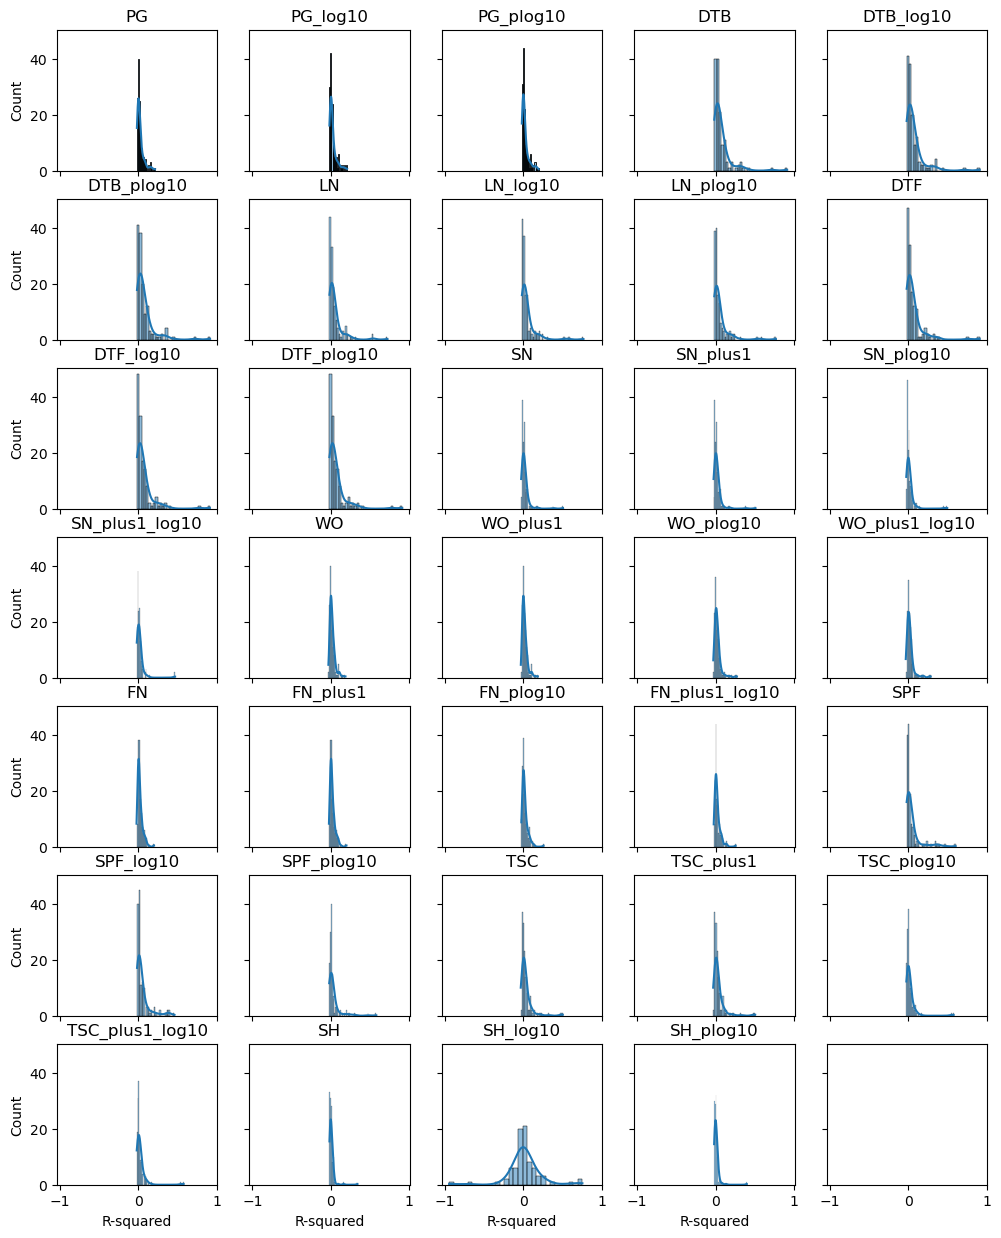

In [5]:
# What is the distribution of R-squared values? How much variance in each fitness label is explained by the models?
fig, ax = plt.subplots(7, 5, figsize=(12, 15), sharex=True, sharey=True)
for i, label in enumerate(lin_res['Label'].unique()):
    sns.histplot(lin_res[lin_res['Label'] == label]['rsquared'], ax=ax[i // 5, i % 5], kde=True)
    ax[i // 5, i % 5].set_title(label)
    ax[i // 5, i % 5].set_xlabel('R-squared')
    ax[i // 5, i % 5].set_ylabel('Count')

In [6]:
# Binary matrix specifying which sets exhibited significant epistasis interactions for each fitness label (1 = significant, 0 = not significant)
set_overlap = lin_res[lin_res['pval_e'] < 0.05].pivot_table(index='Label', columns='Set', values='pval_e', aggfunc='min').T
set_overlap[set_overlap < 0.05] = 1
set_overlap.fillna(0, inplace=True)
set_overlap

Label,DTB,DTB_log10,DTB_plog10,DTF,DTF_log10,DTF_plog10,FN,FN_plog10,FN_plus1,FN_plus1_log10,...,SPF_log10,SPF_plog10,TSC,TSC_plog10,TSC_plus1,TSC_plus1_log10,WO,WO_plog10,WO_plus1,WO_plus1_log10
Set,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# What is the overlap of sets with significant p-values between fitness labels?
set_overlap['Sum_across_labels'] = set_overlap.sum(axis=1)
set_overlap = pd.concat([set_overlap,
    set_overlap.sum(axis=0).rename('Sum_across_sets').to_frame().loc[set_overlap.columns].T],
    axis=0)
set_overlap

Label,DTB,DTB_log10,DTB_plog10,DTF,DTF_log10,DTF_plog10,FN,FN_plog10,FN_plus1,FN_plus1_log10,...,SPF_plog10,TSC,TSC_plog10,TSC_plus1,TSC_plus1_log10,WO,WO_plog10,WO_plus1,WO_plus1_log10,Sum_across_labels
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,16.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
12,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
823,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


<Figure size 640x480 with 0 Axes>

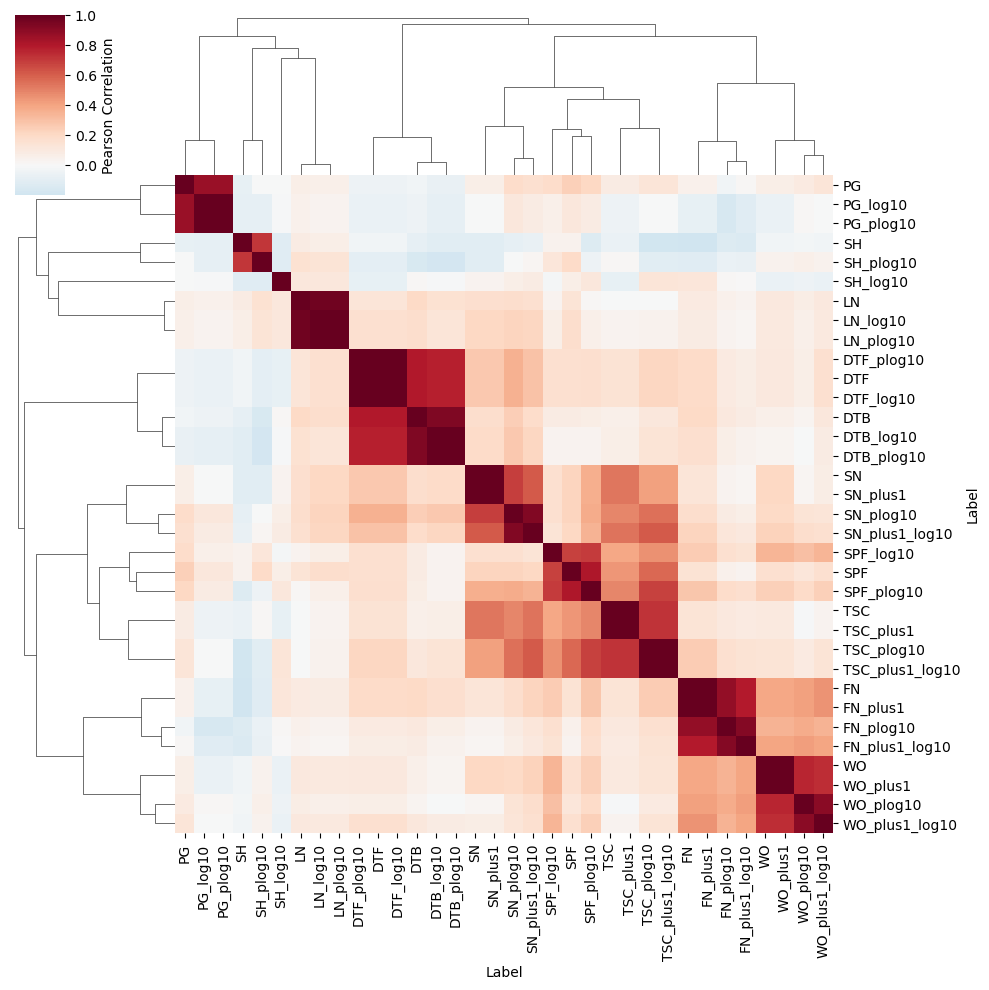

In [8]:
# Which fitness labels revealed epistasis in the same sets? (Pearson correlation)
fig = plt.figure()
sns.clustermap(set_overlap.iloc[:-1,:-1].corr(method='pearson'),
               cmap='RdBu_r', center=0, figsize=(10, 10), method='average',
               cbar_kws={'label': 'Pearson Correlation'})

In [9]:
# How many sets violated the assumptions of linear regression? 1 = violated, 0 = not violated
lin_res['Normality_Violated'] = np.where(lin_res['sw_test_pval'] < 0.05, 1, 0)
lin_res['Homoscedasticity_Violated'] = np.where(lin_res['bp_test_pval'] < 0.05, 1, 0)

violations = lin_res[['Set', 'Label', 'Normality_Violated', 'Homoscedasticity_Violated']].\
    pivot_table(index='Set', columns='Label', values=['Normality_Violated', 'Homoscedasticity_Violated'],
    aggfunc='first')

violations['Homoscedasticity_Violated_Sum'] = violations['Homoscedasticity_Violated'].sum(axis=1)
violations['Normality_Violated_Sum'] = violations['Normality_Violated'].sum(axis=1)

violations = pd.concat([violations,
    violations.sum(axis=0).rename('Sum_across_sets').to_frame().loc[violations.columns].T],
    axis=0)
violations

Homoscedasticity_Violated                             \
Label                                 DTB DTB_log10 DTB_plog10   DTF   
1                                     1.0       0.0        0.0   0.0   
2                                     0.0       1.0        1.0   1.0   
3                                     0.0       0.0        0.0   0.0   
5                                     0.0       0.0        0.0   0.0   
7                                     0.0       0.0        0.0   0.0   
...                                   ...       ...        ...   ...   
812                                   0.0       0.0        0.0   0.0   
813                                   0.0       0.0        0.0   0.0   
815                                   0.0       0.0        0.0   0.0   
823                                   1.0       1.0        1.0   1.0   
Sum_across_sets                      13.0      15.0       15.0  13.0   

                                                                              \
Label           DTF_log10 DTF_plog10    FN FN_plog10 FN_plus1 FN_plus1_log10   
1                     0.0        0.0   0.0       0.0      0.0            0.0   
2                     1.0        1.0   0.0       0.0      0.0            0.0   
3                     0.0        0.0   0.0       0.0      0.0            0.0   
5                     0.0        0.0   0.0       0.0      0.0            0.0   
7                     0.0        0.0   0.0       0.0      0.0            0.0   
...                   ...        ...   ...       ...      ...            ...   
812                   0.0        0.0   0.0       0.0      0.0            0.0   
813                   0.0        0.0   1.0       1.0      1.0            1.0   
815                   0.0        0.0   0.0       0.0      0.0            0.0   
823                   1.0        1.0   0.0       0.0      0.0            0.0   
Sum_across_sets      15.0       15.0  26.0      30.0     26.0           32.0   

                 ... Normality_Violated                                       \
Label            ...                TSC TSC_plog10 TSC_plus1 TSC_plus1_log10   
1                ...                1.0        1.0       1.0             1.0   
2                ...                1.0        1.0       1.0             1.0   
3                ...                1.0        1.0       1.0             1.0   
5                ...                1.0        1.0       1.0             1.0   
7                ...                1.0        1.0       1.0             1.0   
...              ...                ...        ...       ...             ...   
812              ...                0.0        1.0       0.0             1.0   
813              ...                1.0        0.0       1.0             0.0   
815              ...                1.0        1.0       1.0             1.0   
823              ...                1.0        1.0       1.0             1.0   
Sum_across_sets  ...              103.0      138.0     103.0           138.0   

                                                          \
Label               WO WO_plog10 WO_plus1 WO_plus1_log10   
1                  1.0       1.0      1.0            1.0   
2                  1.0       1.0      1.0            1.0   
3                  1.0       1.0      1.0            1.0   
5                  1.0       1.0      1.0            1.0   
7                  1.0       1.0      1.0            1.0   
...                ...       ...      ...            ...   
812                1.0       1.0      1.0            1.0   
813                1.0       1.0      1.0            1.0   
815                1.0       1.0      1.0            1.0   
823                1.0       1.0      1.0            1.0   
Sum_across_sets  138.0     139.0    138.0          139.0   

                Homoscedasticity_Violated_Sum Normality_Violated_Sum  
Label                                                                 
1                                         3.0                   31.0  
2  

Text(0.5, 1.0, 'Homoscedasticity Violations')

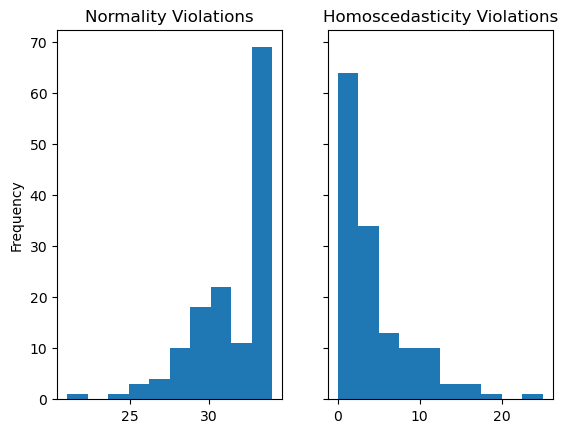

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
violations[['Normality_Violated_Sum']].iloc[:-1].plot(kind='hist', ax=ax[0], legend=False)
ax[0].set_title('Normality Violations')

violations[['Homoscedasticity_Violated_Sum']].iloc[:-1].plot(kind='hist', ax=ax[1], legend=False)
ax[1].set_title('Homoscedasticity Violations')

#### 2. Epistasis as the GI definitions
##### Total Seed Count

In [2]:
tsc = pd.read_csv('../data/20240923_melissa_ara_data/corrected_data/fitness_data_for_Kenia_09232024_TSC_emmeans_epistasis.tsv',
                  index_col=0, header=[0,1], sep='\t')
tsc

TSC_emmean                          TSC_plog10_emmean                      \
          W_DM      W_MA      W_MB W_WT              W_DM      W_MA      W_MB   
Set                                                                             
1     0.732019  0.935668  0.704010  1.0          0.915996  0.964003  0.914628   
2     0.662384  1.125795  0.911411  1.0          0.870448  1.075766  0.974285   
3     0.923355  1.112170  1.085597  1.0          0.943595  1.033846  1.020453   
5     1.056082  0.991984  0.886658  1.0          0.995270  1.006059  0.916697   
7     1.006330  1.073826  0.951357  1.0          0.984891  1.013433  1.003676   
..         ...       ...       ...  ...               ...       ...       ...   
810   1.117533  1.080726  0.969184  1.0          1.019242  1.016744  0.974242   
812   1.053295  1.017996  0.998880  1.0          1.015302  1.011397  0.960770   
813   1.246983  1.236311  1.098568  1.0          1.067977  1.068855  1.039281   
815   0.992081  1.106215  1.011987  1.0          1.088093  1.064426  1.026562   
823   0.851799  0.932436  0.903440  1.0          0.946911  0.974468  0.968266   

         TSC_plus1_emmean            ...                    \
    W_WT             W_DM      W_MA  ... epi_log2_additive   
Set                                  ...                     
1    1.0         0.736819  0.936820  ...          1.326483   
2    1.0         0.669674  1.123079  ...          0.633016   
3    1.0         0.924951  1.109834  ...          0.658490   
5    1.0         1.056016  0.991994  ...          1.240945   
7    1.0         1.006306  1.073546  ...          0.975584   
..   ...              ...       ...  ...               ...   
810  1.0         1.116734  1.080178  ...          1.050311   
812  1.0         1.052908  1.017865  ...          1.028967   
813  1.0         1.244607  1.234038  ...          0.806841   
815  1.0         0.992236  1.104135  ...          0.832465   
823  1.0         0.852239  0.932636  ...          1.098894   

                        TSC_plus1_log10_emmean                           \
    epi_log2_difference                epi_min epi_product epi_additive   
Set                                                                       
1              0.335467               0.001787    0.033149     0.035984   
2              0.371414              -0.099792   -0.169157    -0.170927   
3              0.890724              -0.072964   -0.106396    -0.105737   
5              0.894281               0.078545    0.072969     0.072462   
7              0.832261              -0.018820   -0.032227    -0.032177   
..                  ...                    ...         ...          ...   
810            0.960621               0.044782    0.028612     0.028186   
812            1.025756               0.053433    0.042291     0.041853   
813            1.075599               0.028327   -0.041883    -0.039284   
815            0.866176               0.060578    0.003847     0.004960   
823            0.806811              -0.021236    0.003343     0.004148   

                                                                             
    epi_log2_mani  epi_mean   epi_max epi_log2_additive epi_log2_difference  
Set                                                                          
1        0.033939 -0.022565 -0.046917          1.093937            0.844233  
2       -0.169719 -0.147797 -0.195801          0.812534            0.739853  
3       -0.106186 -0.079289 -0.085614          0.871893            0.929379  
5        0.072823  0.033858 -0.010830          1.111969            0.861038  
7       -0.032211 -0.023637 -0.028454          0.960399            0.971122  
..            ...       ...       ...               ...                 ...  
810      0.028482  0.023654  0.002525          1.032879            0.957871  
812      0.042159  0.028715  0.003998          1.054641            0.943294  
813     -0.041020  0.013742 -0.000843          0.917963            1.026801  
815      0.00

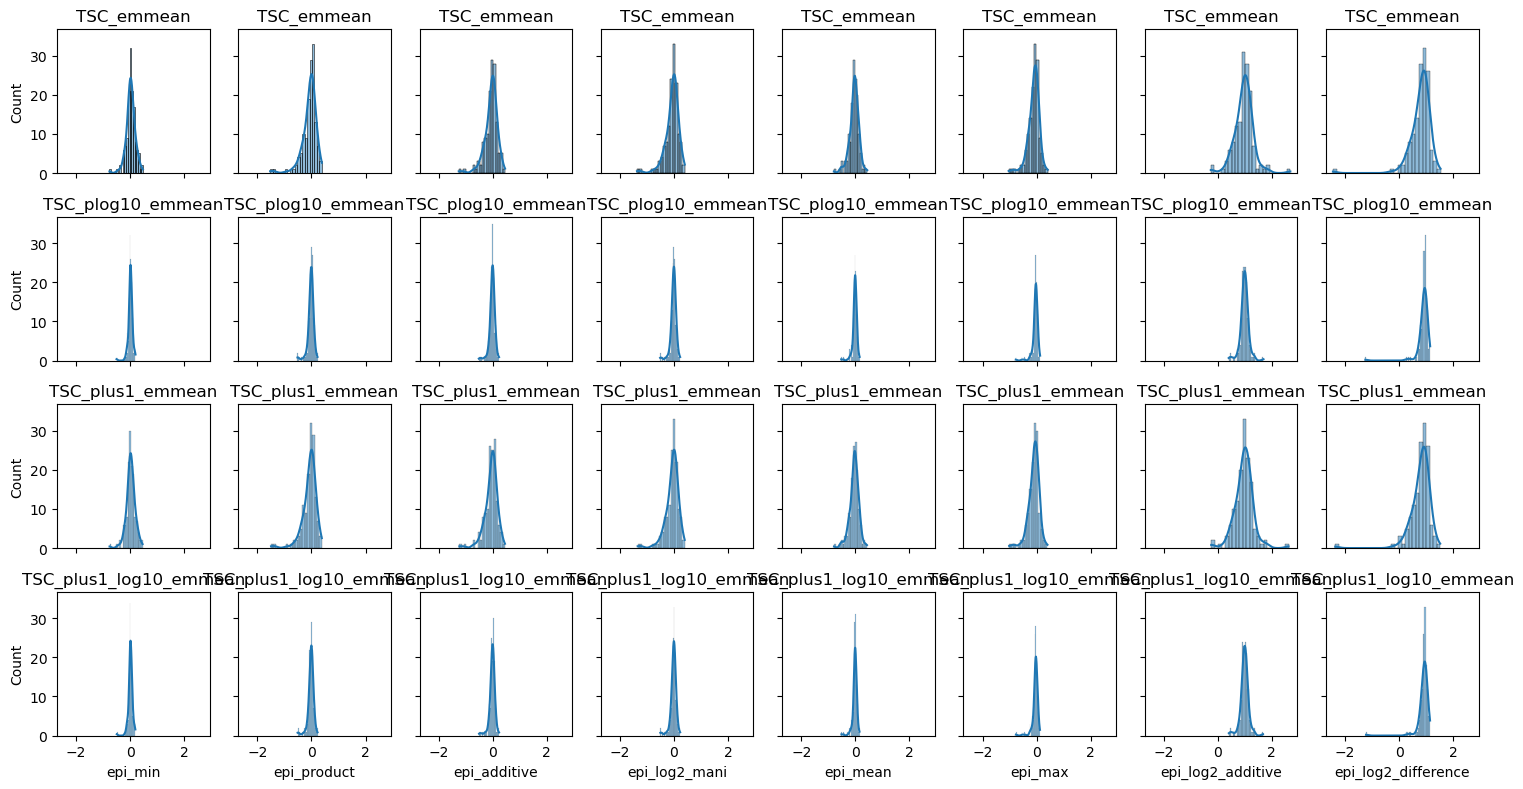

In [7]:
# What are the distribution of epistasis values for different genetic interaction definitions?
fig, ax = plt.subplots(4, 8, figsize=(15, 8), sharex=True, sharey=True)
for i, column in enumerate(tsc.columns[16:]):
    sns.histplot(tsc[column], ax=ax[i // 8, i % 8], kde=True)
    ax[i // 8, i % 8].set_title(f'{column[0]}')
    ax[i // 8, i % 8].set_xlabel(f'{column[1]}')
    ax[i // 8, i % 8].set_ylabel('Count')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

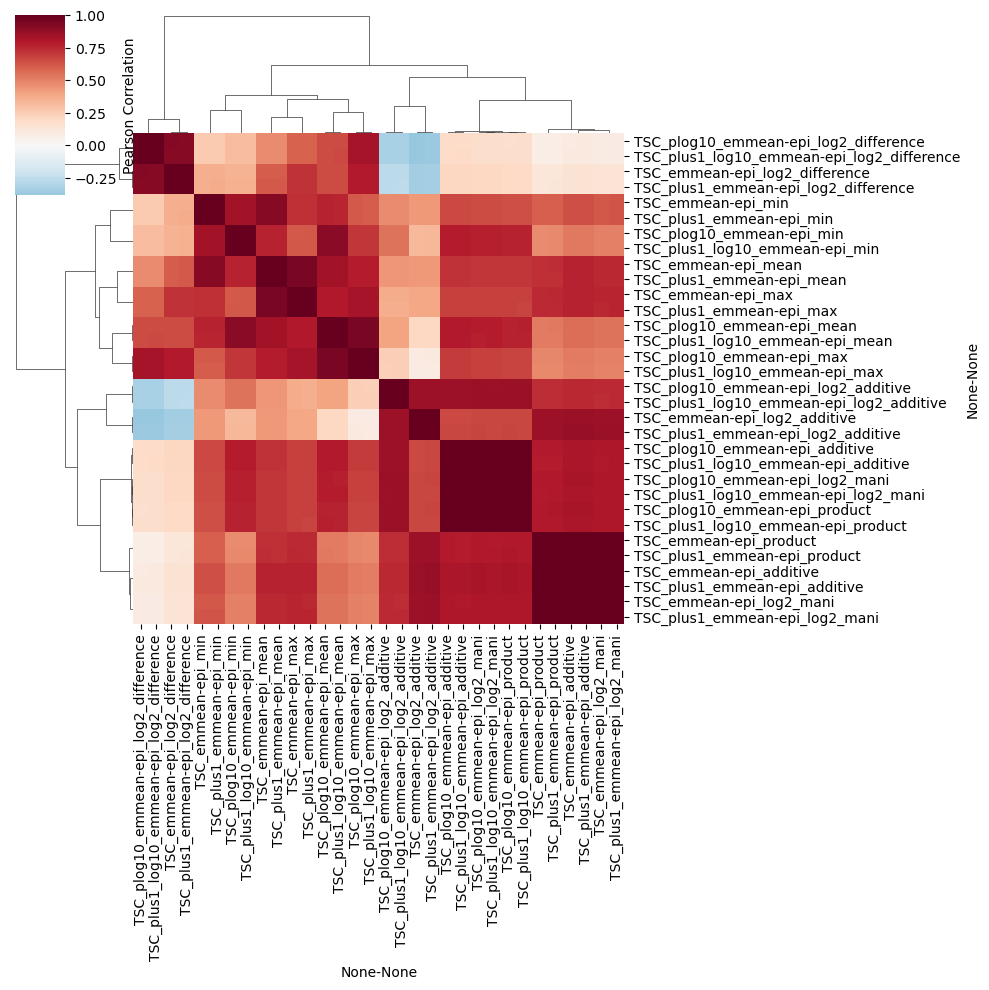

In [8]:
# What is the correlation in epistasis values between different GI definitions for different trait transformations?
fig = plt.figure()
sns.clustermap(tsc.iloc[:,16:].corr(method='pearson'),
               cmap='RdBu_r', center=0, figsize=(10, 10), method='average',
               cbar_kws={'label': 'Pearson Correlation'})